
--- Processing 0000.png ---


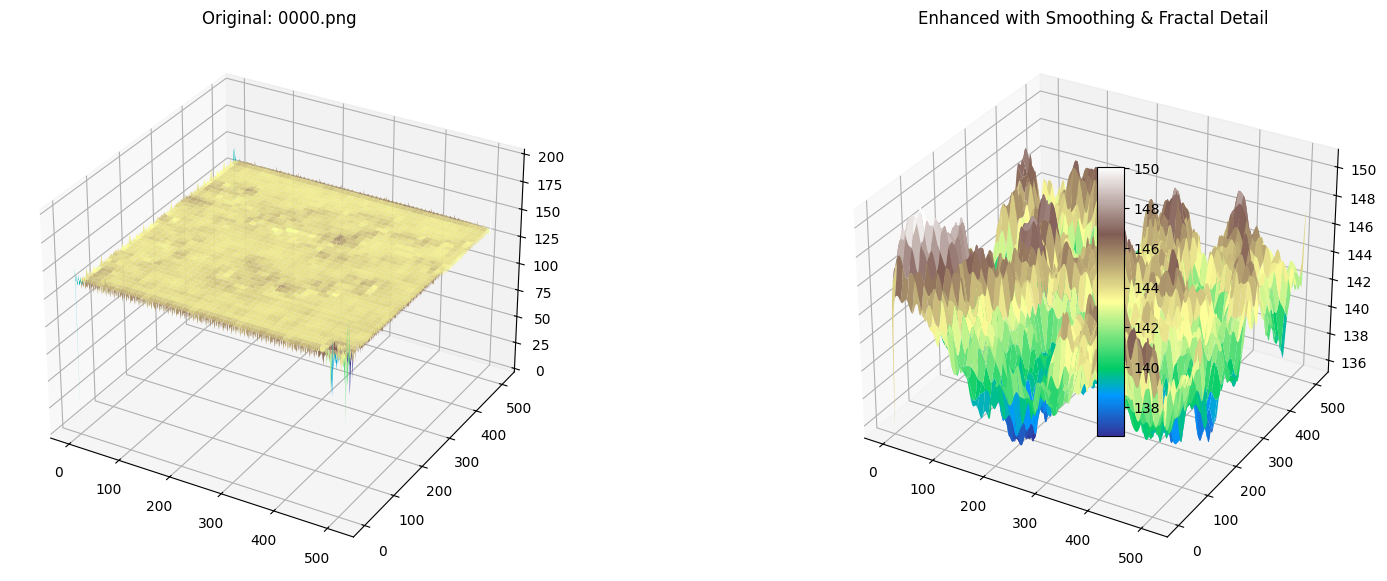

Launching PyVista 3D viewer for enhanced terrain...


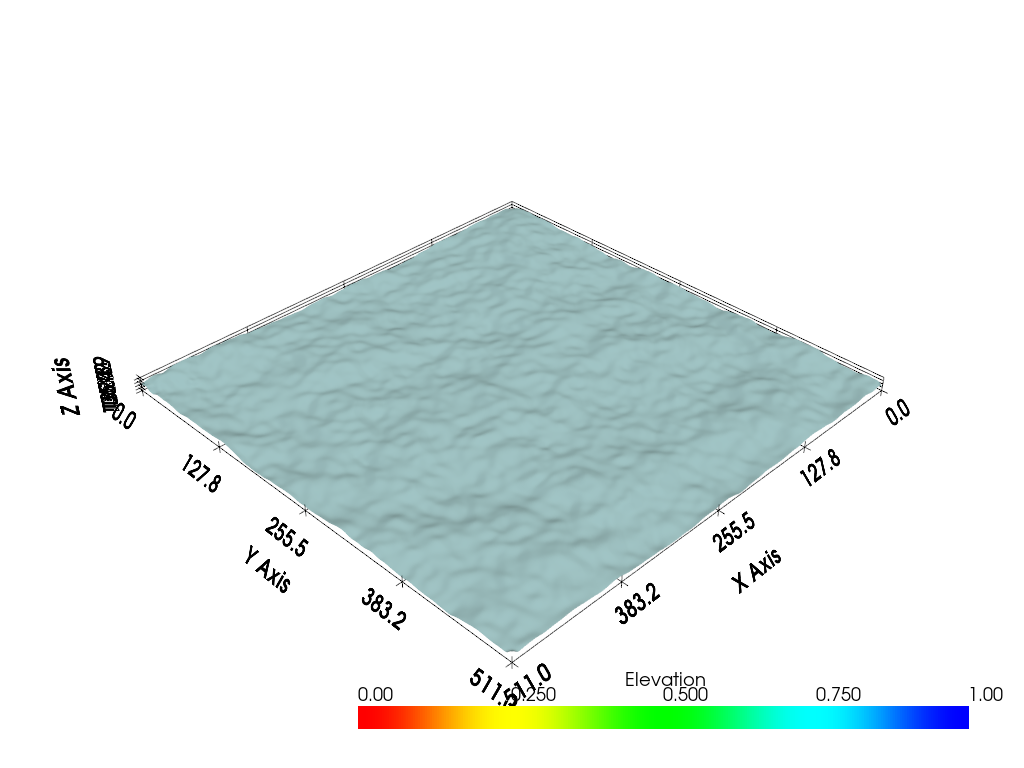

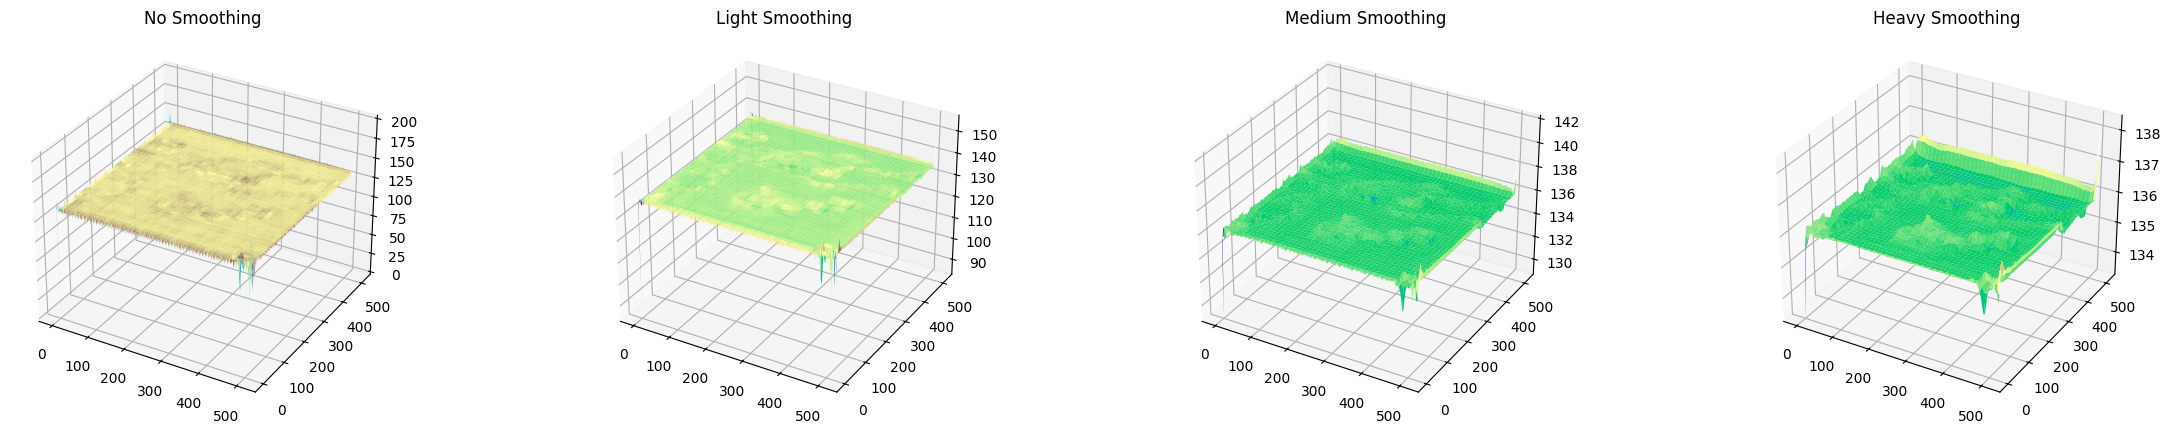


--- Processing 0001.png ---


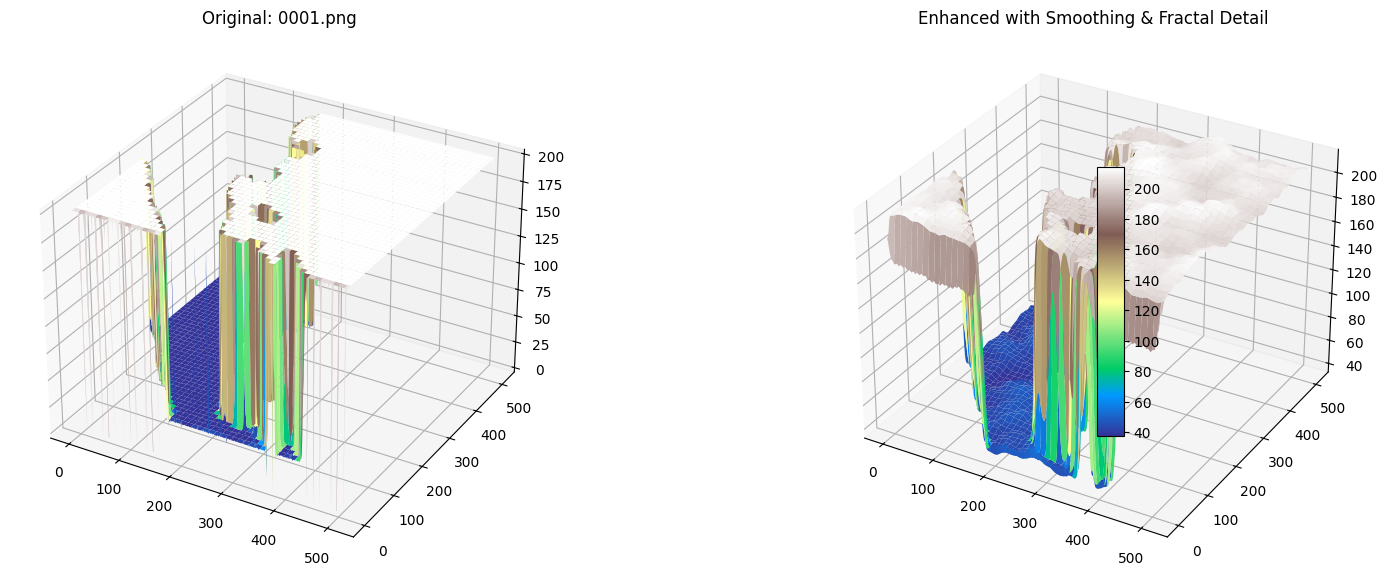

Launching PyVista 3D viewer for enhanced terrain...


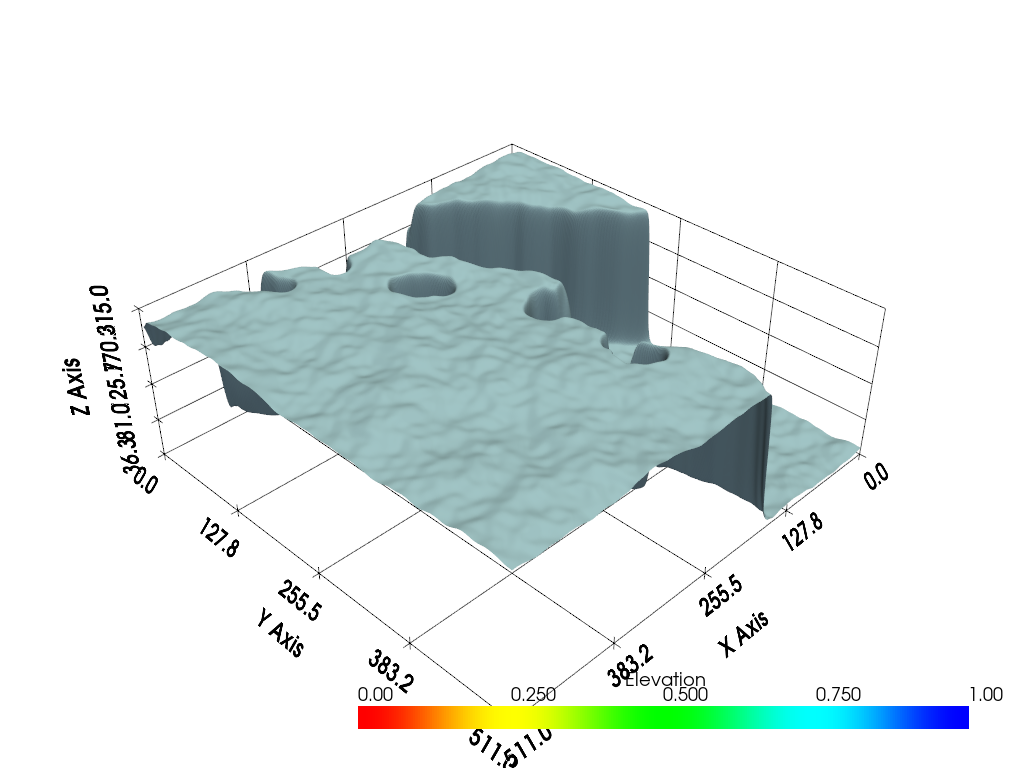

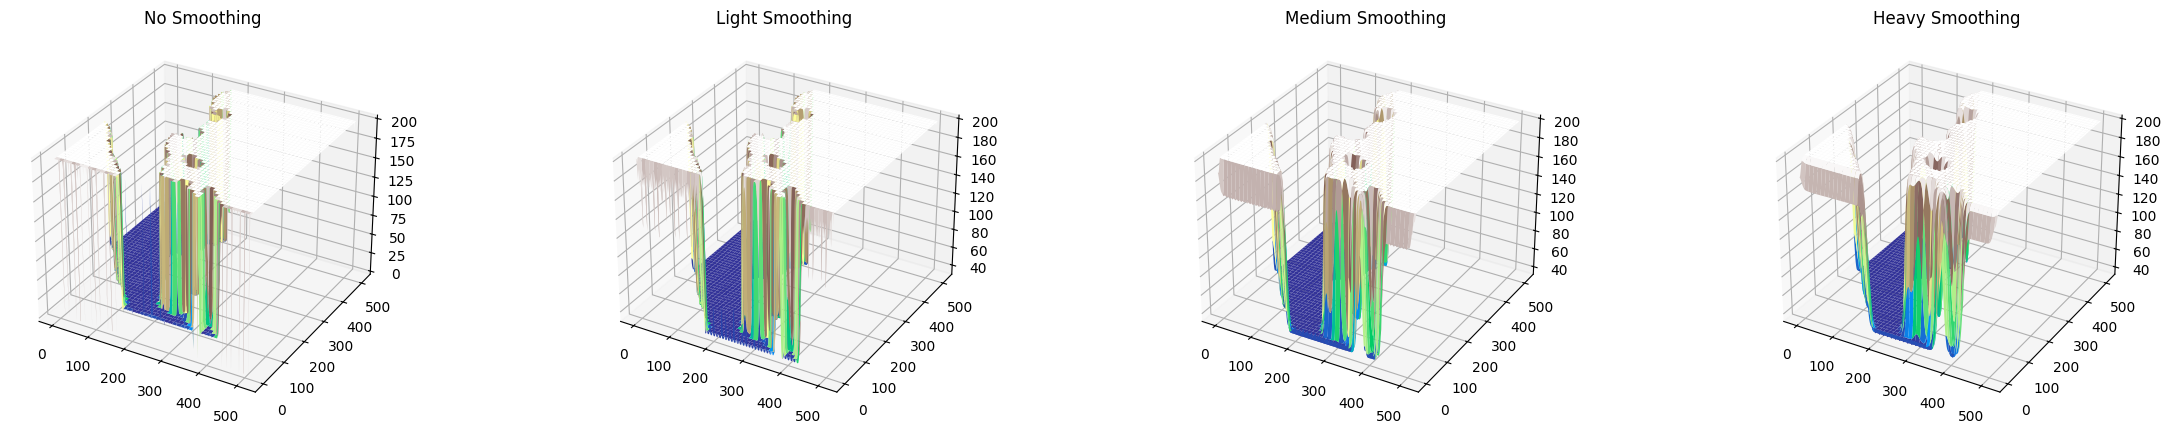


--- Processing 0002.png ---


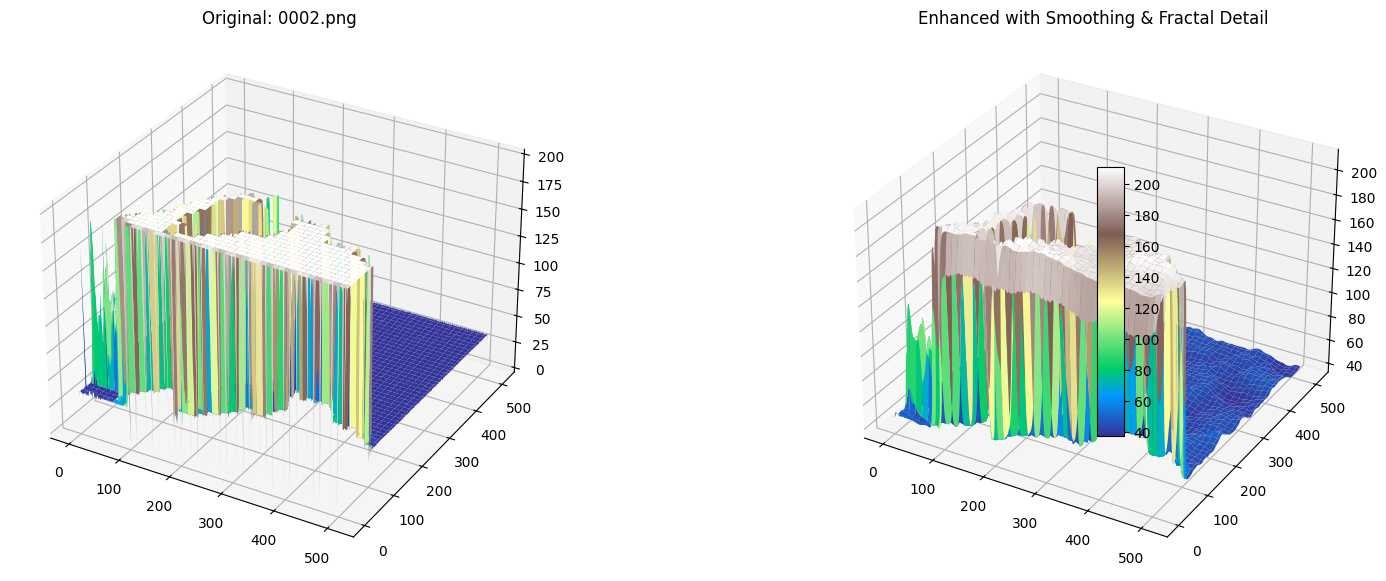

Launching PyVista 3D viewer for enhanced terrain...


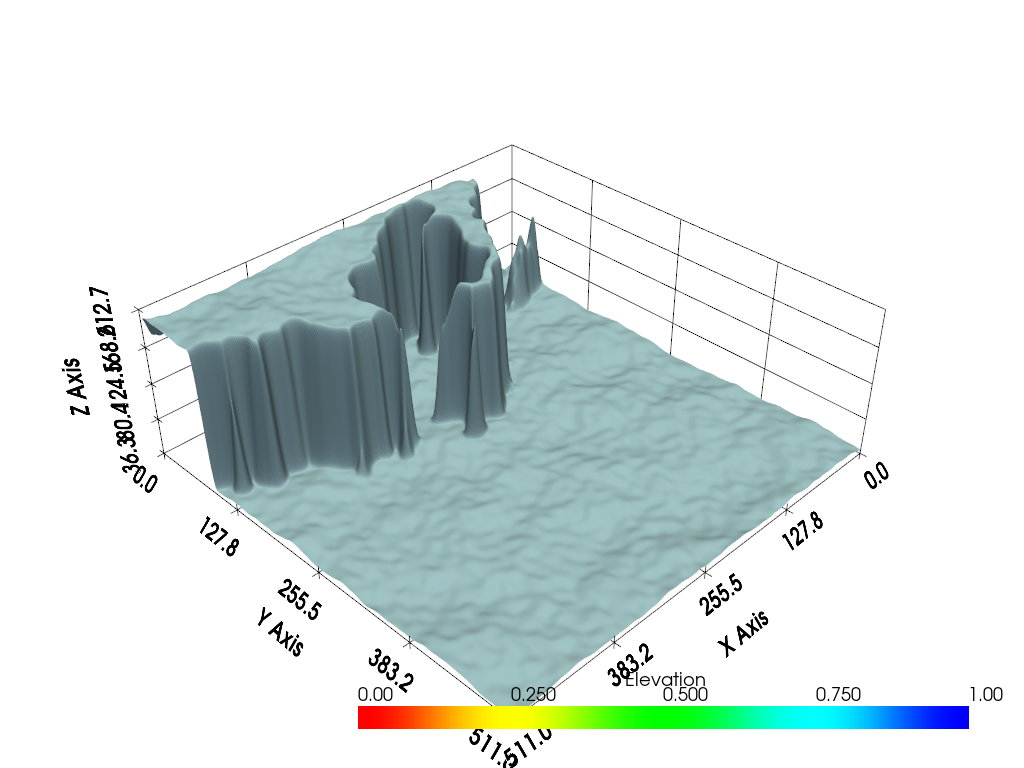

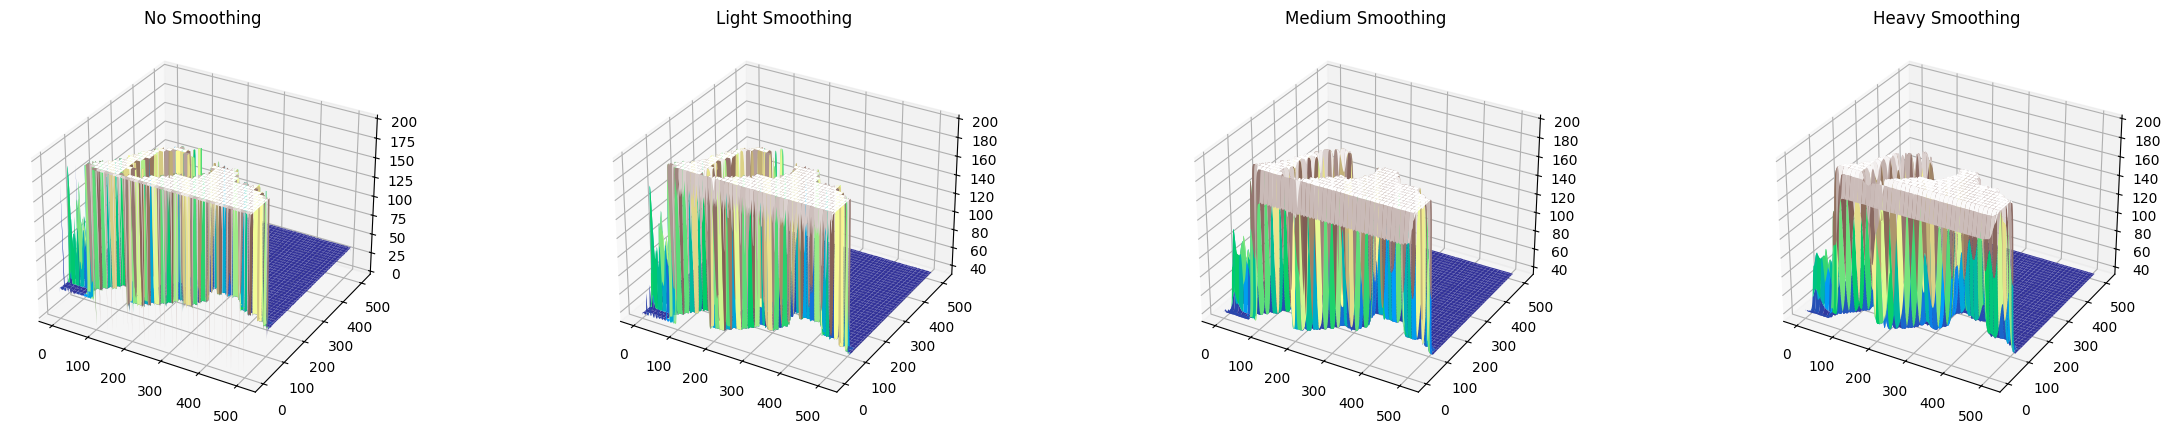


--- Processing 0003.png ---


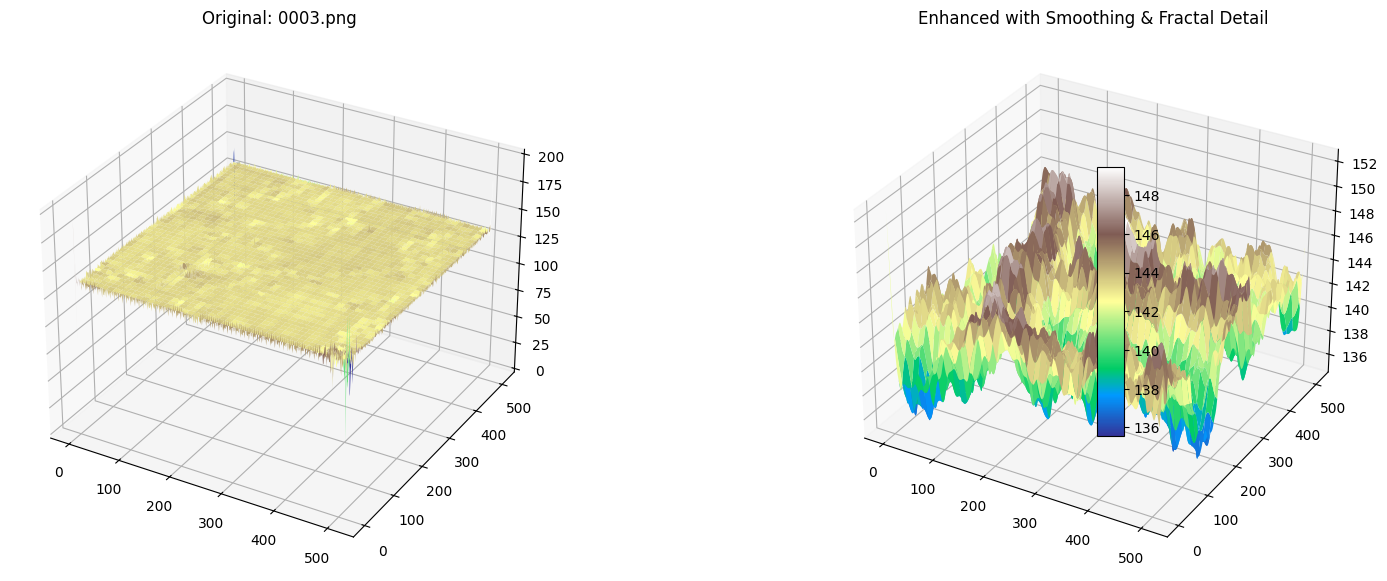

Launching PyVista 3D viewer for enhanced terrain...


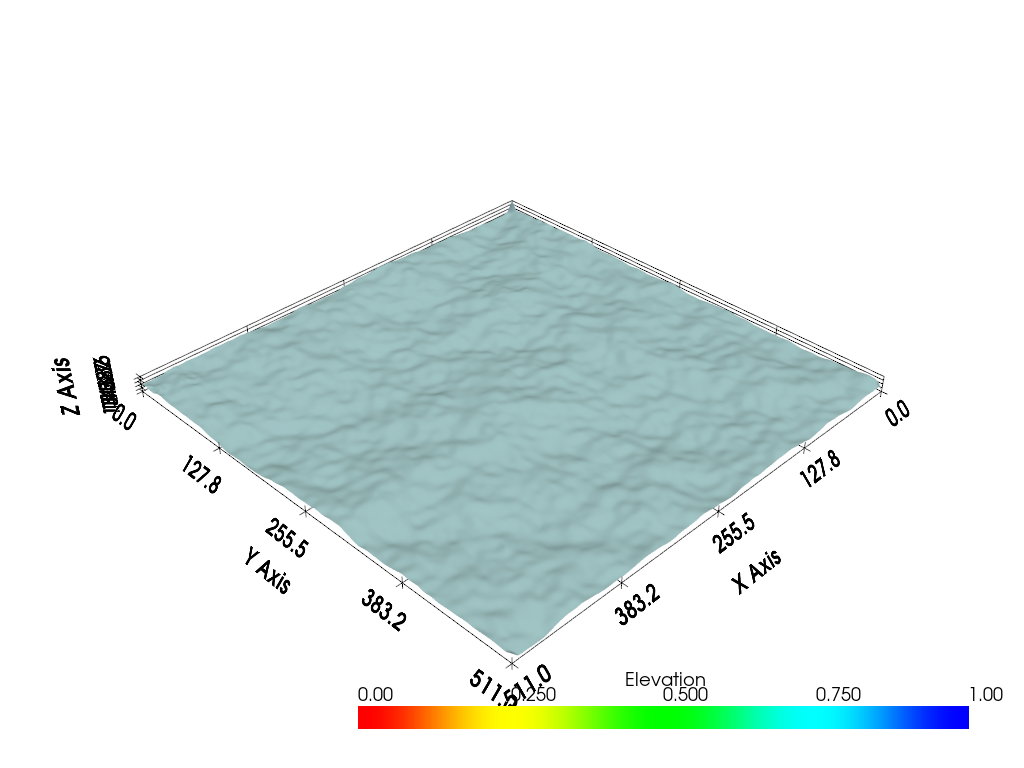

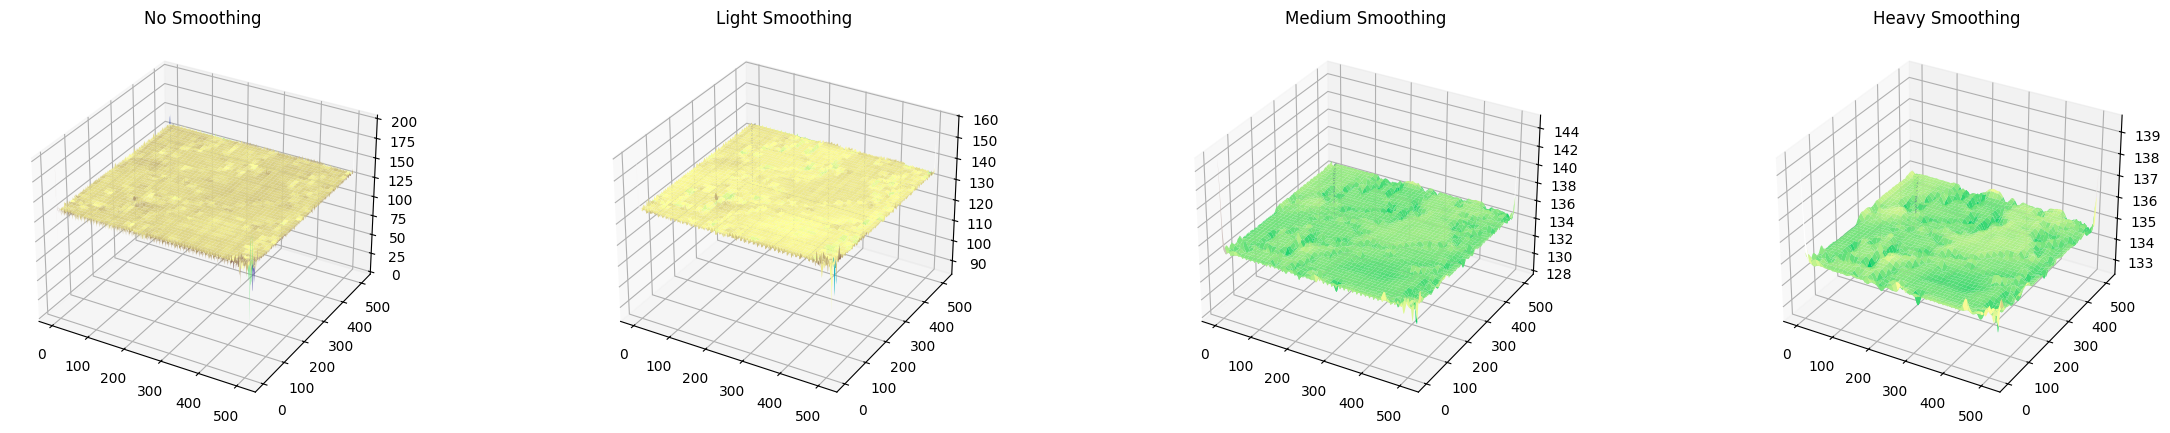


--- Processing 0004.png ---


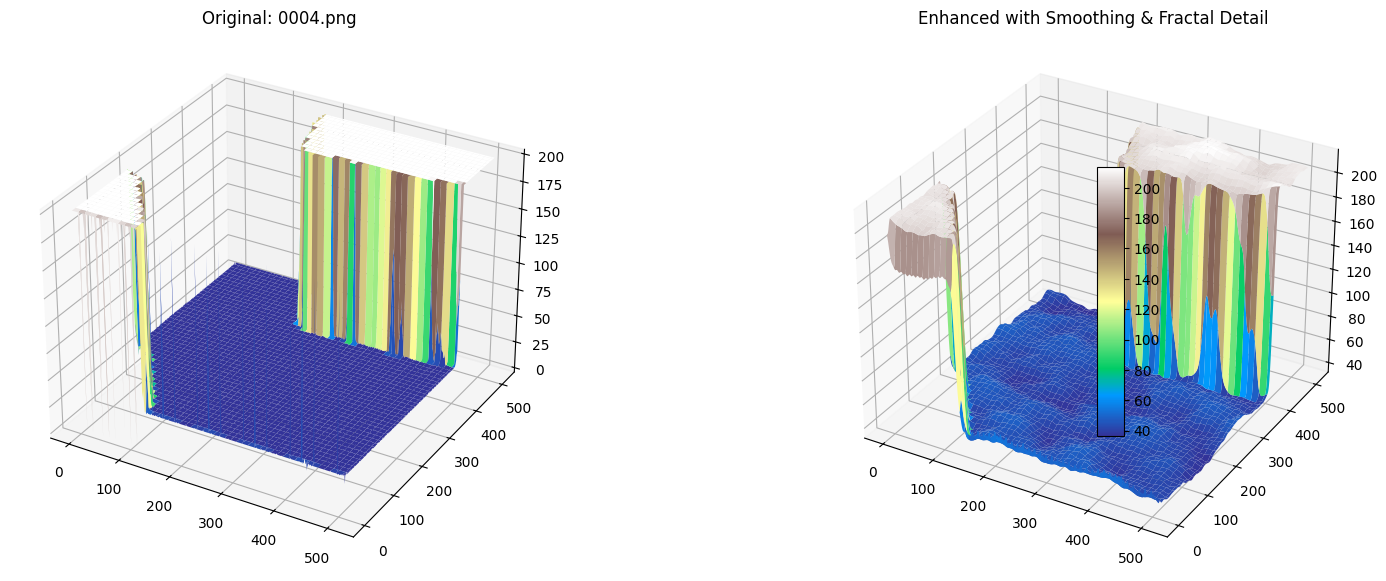

Launching PyVista 3D viewer for enhanced terrain...


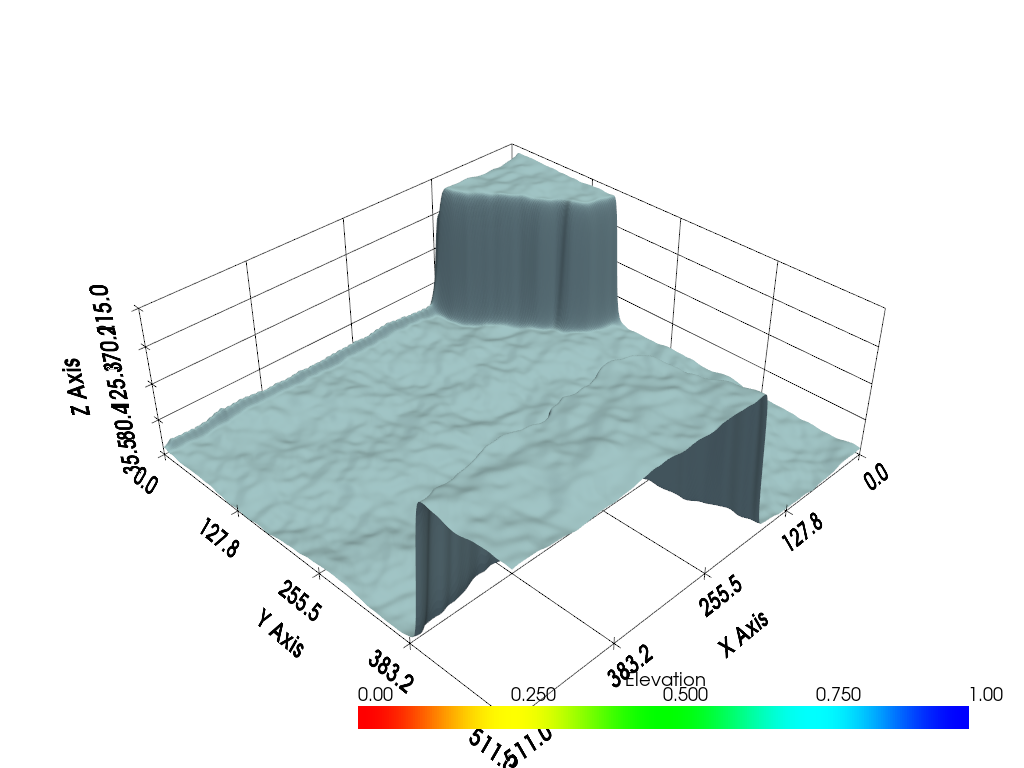

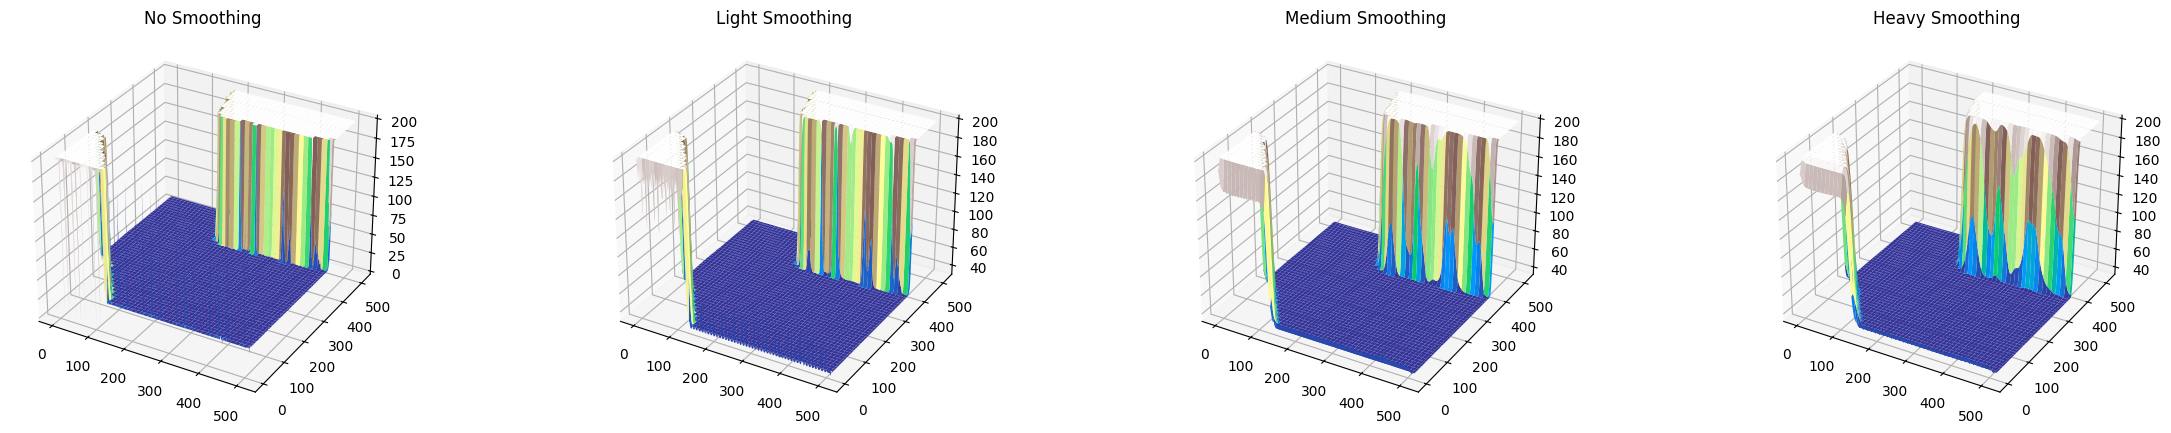

In [ ]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage import gaussian_filter
import warnings

# Suppress specific warnings that aren't important for functionality
warnings.filterwarnings("ignore", category=UserWarning, module="pyvista.jupyter")
warnings.filterwarnings("ignore", message=".*tight_layout.*")

# Try to import optional libraries for enhanced functionality
try:
    import pyvista as pv
    HAS_PYVISTA = True
except ImportError:
    HAS_PYVISTA = False
    print("PyVista not installed—install with `pip install pyvista` for interactive viewing")

try:
    from opensimplex import OpenSimplex
    HAS_OPENSIMPLEX = True
except ImportError:
    HAS_OPENSIMPLEX = False
    print("OpenSimplex not installed—install with `pip install opensimplex` for better fractal detail")

def load_height_map(path, scale_to=None, invert=True):
    """
    Load a single‐channel grayscale PNG height map into a 2D numpy array.
    
    Parameters:
        path: Path to the height map image
        scale_to: Tuple (h_max, h_min) to rescale values from [0,1]→[h_min,h_max]
        invert: If True, inverts the height values (useful if bright=low, dark=high in your GAN output)
    
    Returns:
        2D numpy array of height values
    """
    img = Image.open(path).convert("L")
    arr = np.array(img, dtype=np.float32) / 255.0
    
    if invert:
        # Invert the values (0 becomes 1, 1 becomes 0)
        # This fixes the "upside down" appearance if your GAN produces inverted heightmaps
        arr = 1.0 - arr
    
    if scale_to is not None:
        hi, lo = scale_to
        arr = arr * (hi - lo) + lo
    
    return arr

def smooth_terrain(height_map, sigma=1.0):
    """
    Apply Gaussian smoothing to reduce sharp artifacts in the terrain.
    
    Parameters:
        height_map: 2D numpy array of heights
        sigma: Smoothing strength (higher values = more smoothing)
    
    Returns:
        Smoothed height map
    """
    return gaussian_filter(height_map, sigma=sigma)

def add_opensimplex_detail(height_map, octaves=3, persistence=0.5, scale=10.0):
    """
    Add fractal noise detail to terrain using OpenSimplex noise for enhanced realism.
    
    Parameters:
        height_map: 2D numpy array of heights
        octaves: Number of octaves for the noise (higher = more detail)
        persistence: How much each octave contributes (0-1)
        scale: Height scale of the added detail in map units
    
    Returns:
        Height map with added fractal details
    """
    if not HAS_OPENSIMPLEX:
        return add_numpy_fractal_detail(height_map, octaves, persistence, scale)
        
    h, w = height_map.shape
    detail = np.zeros((h, w))
    
    # Create a new noise generator with a random seed
    noise_gen = OpenSimplex(seed=np.random.randint(0, 1000000))
    
    # Generate OpenSimplex noise with multiple octaves (fractal noise)
    for y in range(h):
        for x in range(w):
            # Start with no noise
            value = 0
            amplitude = 1.0
            frequency = 1.0
            
            # Add contributions from each octave
            for _ in range(octaves):
                # The division values control the "zoom level" of the noise
                nx = x / w * frequency * 5  # Scale factor for better detail
                ny = y / h * frequency * 5
                
                # Add this octave's contribution to the total
                value += noise_gen.noise2(nx, ny) * amplitude
                
                # Prepare for next octave
                amplitude *= persistence
                frequency *= 2
    
            detail[y, x] = value
    
    # Normalize to [0,1] range and then scale to desired height range
    detail = (detail - detail.min()) / (detail.max() - detail.min()) * scale
    
    # Add the detail to the original height map
    return height_map + detail

def add_numpy_fractal_detail(height_map, octaves=3, persistence=0.5, scale=10.0):
    """
    Fallback function: Add fractal-like noise detail using NumPy random functions.
    Used when OpenSimplex is not available.
    
    Parameters:
        height_map: 2D numpy array of heights
        octaves: Number of octaves for the noise
        persistence: How much each octave contributes
        scale: Height scale of the added detail
    
    Returns:
        Height map with added fractal-like details
    """
    h, w = height_map.shape
    detail = np.zeros((h, w))
    
    # Generate multiple scales of random noise
    for octave in range(octaves):
        # Scale for this octave (smaller with each octave)
        freq = 2**octave
        amp = persistence**octave
        
        # Create noise pattern at this scale
        octave_size = (max(h // freq, 1), max(w // freq, 1))
        noise = np.random.rand(*octave_size)
        
        # Resize to full size using bilinear interpolation
        from scipy.ndimage import zoom
        zoomed = zoom(noise, (h/noise.shape[0], w/noise.shape[1]), order=1)
        
        # Add this octave's contribution
        detail += zoomed * amp
    
    # Normalize and scale
    detail = (detail - detail.min()) / (detail.max() - detail.min()) * scale
    
    # Add the detail to the original height map
    return height_map + detail

def enhance_terrain(height_map, smooth_sigma=1.0, add_detail=True, 
                   detail_octaves=3, detail_persistence=0.5, detail_scale=10.0):
    """
    Complete terrain enhancement pipeline.
    First smooths the terrain, then optionally adds fractal detail.
    
    Parameters:
        height_map: Original height map
        smooth_sigma: Smoothing strength
        add_detail: Whether to add fractal detail
        detail_*: Parameters for fractal detail generation
    
    Returns:
        Enhanced height map
    """
    # First smooth the terrain
    terrain = smooth_terrain(height_map, sigma=smooth_sigma)
    
    # Then add fractal detail if requested
    if add_detail:
        if HAS_OPENSIMPLEX:
            terrain = add_opensimplex_detail(terrain, 
                                           octaves=detail_octaves,
                                           persistence=detail_persistence,
                                           scale=detail_scale)
        else:
            terrain = add_numpy_fractal_detail(terrain, 
                                             octaves=detail_octaves,
                                             persistence=detail_persistence,
                                             scale=detail_scale)
    
    return terrain

def plot_matplotlib_3d(z, title="3D Terrain", cmap="terrain", elev=30, azim=-60):
    """
    Simple static 3D surface using Matplotlib.
    
    Parameters:
        z: 2D numpy array of heights
        title: Plot title
        cmap: Colormap to use
        elev: Elevation viewing angle
        azim: Azimuth viewing angle
    """
    h, w = z.shape
    x = np.arange(w)
    y = np.arange(h)
    x, y = np.meshgrid(x, y)
    
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection="3d")
    surf = ax.plot_surface(
        x, y, z,
        cmap=cmap, 
        linewidth=0, 
        antialiased=True,
        rcount=200, ccount=200
    )
    fig.colorbar(surf, shrink=0.5, aspect=10)
    ax.set_title(title)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Elevation")
    
    # Set the viewing angle for better visualization
    ax.view_init(elev=elev, azim=azim)
    
    plt.show()

def plot_comparison(original, enhanced, titles=["Original", "Enhanced"], elev=30, azim=-60):
    """
    Plot original and enhanced terrain side by side for comparison.
    
    Parameters:
        original: Original height map
        enhanced: Enhanced height map
        titles: Titles for the two plots
        elev: Elevation viewing angle
        azim: Azimuth viewing angle
    """
    h, w = original.shape
    x = np.arange(w)
    y = np.arange(h)
    x, y = np.meshgrid(x, y)
    
    fig = plt.figure(figsize=(16, 7))
    
    # Original terrain
    ax1 = fig.add_subplot(121, projection="3d")
    surf1 = ax1.plot_surface(x, y, original, cmap="terrain", 
                           linewidth=0, antialiased=True)
    ax1.set_title(titles[0])
    ax1.view_init(elev=elev, azim=azim)  # Set viewing angle
    
    # Enhanced terrain
    ax2 = fig.add_subplot(122, projection="3d")
    surf2 = ax2.plot_surface(x, y, enhanced, cmap="terrain", 
                           linewidth=0, antialiased=True)
    ax2.set_title(titles[1])
    ax2.view_init(elev=elev, azim=azim)  # Set viewing angle
    
    # Add a colorbar that maps values to colors
    fig.colorbar(surf2, ax=[ax1, ax2], shrink=0.5, aspect=10)
    
    # Instead of tight_layout, manually adjust spacing
    plt.subplots_adjust(wspace=0.3, left=0.05, right=0.95)
    
    plt.show()

def plot_all_variations(height_map, smooth_sigmas=[0.0, 1.0, 3.0], 
                       titles=None, elev=30, azim=-60):
    """
    Show multiple variations of smoothing parameters for comparison.
    
    Parameters:
        height_map: Original height map
        smooth_sigmas: List of smoothing values to try
        titles: Optional custom titles
        elev: Elevation viewing angle
        azim: Azimuth viewing angle
    """
    n = len(smooth_sigmas)
    fig = plt.figure(figsize=(6*n, 5))
    
    if titles is None:
        titles = [f"Smoothing: {s}" for s in smooth_sigmas]
    
    h, w = height_map.shape
    x = np.arange(w)
    y = np.arange(h)
    x, y = np.meshgrid(x, y)
    
    for i, sigma in enumerate(smooth_sigmas):
        # Process terrain with current smoothing level
        processed = smooth_terrain(height_map, sigma=sigma)
        
        # Create subplot
        ax = fig.add_subplot(1, n, i+1, projection="3d")
        surf = ax.plot_surface(x, y, processed, cmap="terrain", 
                              linewidth=0, antialiased=True)
        ax.set_title(titles[i])
        ax.view_init(elev=elev, azim=azim)  # Set viewing angle
    
    plt.subplots_adjust(wspace=0.4, left=0.05, right=0.95)
    plt.show()

def plot_pyvista_terrain(z, name="terrain"):
    """
    Interactive terrain plot using PyVista.
    
    Parameters:
        z: 2D numpy array of heights
        name: Title for the visualization
    """
    if not HAS_PYVISTA:
        print("PyVista not available. Skipping interactive plot.")
        return
    
    h, w = z.shape
    # Create grid of points
    x = np.arange(w)
    y = np.arange(h)
    x, y = np.meshgrid(x, y)
    # Flatten
    pts = np.column_stack((x.flatten(), y.flatten(), z.flatten()))
    
    # Build StructuredGrid: dimensions are (nx, ny, nz)
    grid = pv.StructuredGrid()
    grid.points = pts
    grid.dimensions = (w, h, 1)
    
    # Plot
    pl = pv.Plotter()
    pl.add_mesh(grid, show_edges=False, cmap="terrain")
    pl.add_scalar_bar("Elevation")
    pl.show_grid()
    
    # Try to enable better visualization if possible
    try:
        pl.view_isometric()  # Better default view
    except:
        pass  # If this fails, just use default view
        
    try:
        pl.show(title=name)
    except:
        print("PyVista interactive rendering failed - you may need to install additional dependencies")
        # Try a static screenshot instead
        pl.screenshot(f"{name.replace(' ', '_')}_static.png")

def process_all_terrain_examples(directory, 
                               max_examples=5, 
                               invert=True,
                               smooth_sigma=3.0,
                               detail_octaves=4, 
                               detail_persistence=0.6, 
                               detail_scale=15.0,
                               show_comparison=True,
                               show_pyvista=True,
                               elev=30,
                               azim=-60):
    """
    Process all terrain examples in a directory with the enhanced visualization pipeline.
    
    Parameters:
        directory: Directory containing height map images
        max_examples: Maximum number of examples to process
        invert: Whether to invert height values
        smooth_*: Parameters for smoothing
        detail_*: Parameters for detail enhancement
        show_comparison: Whether to show side-by-side comparison plots
        show_pyvista: Whether to attempt PyVista visualization
        elev/azim: Viewing angles for 3D plots
    """
    # Check if directory exists
    if not os.path.exists(directory):
        print(f"Directory not found: {directory}")
        return
    
    # Get image files
    valid_extensions = ['.png', '.jpg', '.jpeg', '.tif', '.tiff']
    files = [f for f in os.listdir(directory) 
            if os.path.splitext(f.lower())[1] in valid_extensions]
    
    # Limit number of examples
    files = sorted(files)[:max_examples]
    
    for fn in files:
        path = os.path.join(directory, fn)
        
        print(f"\n--- Processing {fn} ---")
        
        # Load original height map with possible inversion
        z_original = load_height_map(path, scale_to=(200, 0), invert=invert)
        
        # Create enhanced version with smoothing and fractal detail
        z_enhanced = enhance_terrain(
            z_original, 
            smooth_sigma=smooth_sigma,        # Stronger smoothing for extreme artifacts
            add_detail=True,                  # Add detail to make it more natural
            detail_octaves=detail_octaves,    # More octaves = more varied detail
            detail_persistence=detail_persistence,  # Controls how much smaller details contribute
            detail_scale=detail_scale         # Controls height of added details
        )
        
        # Show side-by-side comparison if requested
        if show_comparison:
            plot_comparison(z_original, z_enhanced, 
                           titles=[f"Original: {fn}", "Enhanced with Smoothing & Fractal Detail"],
                           elev=elev, azim=azim)
        
        # Interactive visualization if PyVista is available and requested
        if show_pyvista and HAS_PYVISTA:
            print("Launching PyVista 3D viewer for enhanced terrain...")
            plot_pyvista_terrain(z_enhanced, name=f"Enhanced {fn}")

        # Also visualize different smoothing levels (optional)
        # Comment out if not needed
        plot_all_variations(z_original, 
                           smooth_sigmas=[0.0, 1.0, 3.0, 5.0],
                           titles=["No Smoothing", "Light Smoothing", 
                                   "Medium Smoothing", "Heavy Smoothing"],
                           elev=elev, azim=azim)

def main():
    """Main function to run the terrain visualization and enhancement pipeline."""
    # Directories containing your generated heightmaps
    gen_dir = "gen_images"
    # real_dir = "real_images"  # Uncomment if needed
    
    # Process all terrain examples with enhanced visualization
    process_all_terrain_examples(
        directory=gen_dir,
        max_examples=5,          # Limit number of examples to process
        invert=True,             # Invert heights to fix upside-down appearance
        smooth_sigma=3.0,        # Stronger smoothing for extreme artifacts
        detail_octaves=4,        # More octaves = more detailed terrain
        detail_persistence=0.6,  # How much each octave contributes
        detail_scale=15.0,       # Height of added detail features
        show_comparison=True,    # Show side-by-side comparison
        show_pyvista=True,       # Show PyVista visualization if available
        elev=30,                 # Elevation viewing angle
        azim=-60                 # Azimuth viewing angle
    )
    
    # Uncomment to process real examples if available
    # process_all_terrain_examples(real_dir)

if __name__ == "__main__":
    main()